# Capstone Project 

## Venues Data Analysis of the cities with the highest population in Ecuador.

Applied Data Science Capstone by IBM/Coursera

# Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Analysis](#analysis)
* [Results](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will explore the common venues of the twenty most populous cities in Ecuador. Also, we will determine if there is any trend between the types of venues and the cities of a region. Specifically, this report will be targeted to stakeholders interested in opening a new business related with tourism in Ecuador.

Since the tourism is one of the most important economic and cultural activities for any country. This analysis also could be interesting to travelers or tourists who want to know about the most common venues that they can enjoy in each analyzed city.

## Data <a name="data"></a>
Following data sources will be needed to extract/generate the required information:

- Data of ecuadorian cities with their population will be obtained from the website of the National Institute of Statistics and Censuses of Ecuador.
- Coordinates of the selected cities will be obtained using python's package geocoder.
- Common venues will be obtained using Foursquare API.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geocoder
import geocoder # import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!pip install folium
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 98 kB 9.2 MB/s  eta 0:00:01
     |████████████████████████████████| 93 kB 2.7 MB/s  eta 0:00:01
Libraries imported.


In [ ]:
# Load data of cities and population direct from website
# dataCities = pd.read_excel('https://www.ecuadorencifras.gob.ec/wp-content/plugins/download-monitor/download.php?id=311&force=1',skiprows = 8, usecols = 'B:H')
# dataCities = dataCities.dropna()
# dataCities.head()

Load the dataframe previously downloaded from National Institute of Statistics and Censuses of Ecuador. Find more data in https://www.ecuadorencifras.gob.ec/informacion-censal-cantonal/

In [4]:
# The code was removed by Watson Studio for sharing.

In [5]:
body = client_2d526692f0454491be11eb2b0fc1e286.get_object(Bucket='coursera-donotdelete-pr-b8jlfs1zx2sstm',Key='2_Densidad_Pobla_Nac_Prov_Cant_Parr.XLSX')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# Read it using BytesIO connector library function due to the Attribute Error seek
dataCities = pd.read_excel(BytesIO(body.read()), skiprows = 8, usecols = 'B:H')
dataCities = dataCities.dropna()
dataCities.head()

,Código,Nombre de provincia,Nombre de canton,Nombre de parroquia,Población,Superficie de la parroquia (km2),Densidad Poblacional
0,010150,AZUAY,CUENCA,CUENCA,331888.0,70.59,4701.629126
1,010151,AZUAY,CUENCA,BAÑOS,16851.0,326.71,51.577852
2,010152,AZUAY,CUENCA,CUMBE,5546.0,70.84,78.289102
3,010153,AZUAY,CUENCA,CHAUCHA,1297.0,313.31,4.139670
4,010154,AZUAY,CUENCA,CHECA (JIDCAY),2741.0,62.81,43.639548


In [6]:
# Sort data by population
dataCities.sort_values(by='Población',ascending=False, inplace=True)

In [7]:
#Select only the 20 most populated cities and change column names for a better analysis
topCities = dataCities.head(20).copy()
topCities.columns = ['code', 'province', 'division', 'city', 'population', 'subdivision_area', 'population_density']

# Eliminate the values in parentheses for the city column
topCities["city"] = topCities["city"].str.replace(r"(\s*\(.*?\)\s*)", "").str.strip()
topCities.head()

,code,province,division,city,population,subdivision_area,population_density
388,090150,GUAYAS,GUAYAQUIL,GUAYAQUIL,2291158.0,2493.86,918.719575
780,170150,PICHINCHA,QUITO,QUITO,1619146.0,372.39,4347.984640
0,010150,AZUAY,CUENCA,CUENCA,331888.0,70.59,4701.629126
1002,230150,SANTO DOMINGO,SANTO DOMINGO DE LOS TSACHILAS,SANTO DOMINGO DE LOS COLORADOS,305632.0,1092.89,279.654860
261,070150,EL ORO,MACHALA,MACHALA,241606.0,207.09,1166.671495


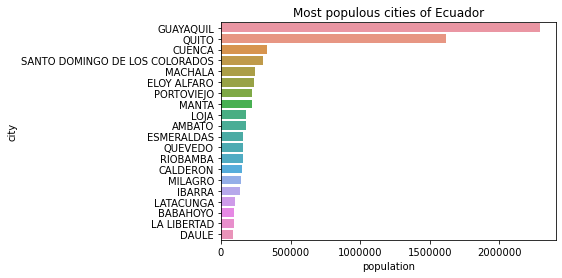

In [8]:
import seaborn as sns
import matplotlib as plt

ax = sns.barplot(x="population",y="city", data=topCities)
ax.set_title('Most populous cities of Ecuador')
ax.get_xaxis().get_major_formatter().set_scientific(False)

#### Use geocode to get the coordinates of the most populated cities

In [9]:
# Define a function to get coordinates
def get_latlng(name):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Ecuador'.format(name))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [10]:
# call the function to get the coordinates of the selected cities
coords = [get_latlng(i) for i in topCities["city"].tolist()]

In [11]:
citiesCoords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
citiesCoords['Cities'] = topCities["city"].tolist()
citiesCoords['Population'] = topCities["population"].tolist()

citiesCoords

,Latitude,Longitude,Cities,Population
0,-2.15960,-79.92830,GUAYAQUIL,2291158.0
1,-0.20565,-78.50888,QUITO,1619146.0
2,-2.89310,-78.99410,CUENCA,331888.0
3,-0.25000,-79.15000,SANTO DOMINGO DE LOS COLORADOS,305632.0
4,-3.26267,-79.96053,MACHALA,241606.0
5,-2.18273,-79.81740,ELOY ALFARO,235769.0
6,-1.05563,-80.45318,PORTOVIEJO,223086.0
7,-0.98109,-80.69669,MANTA,221122.0
8,-4.02156,-79.20295,LOJA,180617.0
9,-1.24917,-78.62997,AMBATO,178538.0


In [12]:
# Get Ecuador coords
geo = geocoder.arcgis('Ecuador')
latitudeEcu = geo.latlng[0]
longitudeEcu = geo.latlng[1]
print('Coordinate of Ecuador: ', latitudeEcu, longitudeEcu)

Coordinate of Ecuador:  -1.428836290999925 -78.77523855199996


In [13]:
# create map of Ecuadorian cities using latitude and longitude values
map1 = folium.Map(location=[latitudeEcu, longitudeEcu], zoom_start=7)

# add markers to map
for lat, lng, label in zip(citiesCoords['Latitude'], citiesCoords['Longitude'], citiesCoords['Cities']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map1)  
    folium.Circle([lat, lng],
                    radius=5000).add_to(map1)
    
map1

#### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info of venues in each city.

In [14]:
# The code was removed by Watson Studio for sharing.

In [15]:
# Get all the categories available in Foursquare
urlCat = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)

category_results = requests.get(urlCat).json()
all_categories = {}

for i in range(len(category_results['response']['categories'])):
    venues = category_results['response']['categories'][i]['name']
    all_categories[venues] = i

print(all_categories)

{'Arts & Entertainment': 0, 'College & University': 1, 'Event': 2, 'Food': 3, 'Nightlife Spot': 4, 'Outdoors & Recreation': 5, 'Professional & Other Places': 6, 'Residence': 7, 'Shop & Service': 8, 'Travel & Transport': 9}


Due to this analysis is focused on tourism, we will analyze the main categories related with this industry. The chosen categories from Foursqure API are: 'Arts & Entertainment','Food' and 'Travel & Transport'.

In [16]:
# Get required subcategories from the categories chosen
touristCategories = []
queryCategories = ['Arts & Entertainment', 'Nightlife Spot', 'Food', 'Travel & Transport']

for i in queryCategories:
    key = all_categories.get(i)
    venues = category_results['response']['categories'][key]['name']
    touristCategories.append(venues)
    for j in range(len(category_results['response']['categories'][key]['categories'])):
        sub_venues = category_results['response']['categories'][key]['categories'][j]['name']
        touristCategories.append(sub_venues)
        
len(touristCategories)

177

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    nearby_venues = nearby_venues[nearby_venues['Venue Category'].isin(touristCategories)]
    
    return(nearby_venues)

In [18]:
citiesVenues = getNearbyVenues(names=citiesCoords['Cities'],
                                   latitudes=citiesCoords['Latitude'],
                                   longitudes=citiesCoords['Longitude']
                                  )


GUAYAQUIL
QUITO
CUENCA
SANTO DOMINGO DE LOS COLORADOS
MACHALA
ELOY ALFARO
PORTOVIEJO
MANTA
LOJA
AMBATO
ESMERALDAS
QUEVEDO
RIOBAMBA
CALDERON
MILAGRO
IBARRA
LATACUNGA
BABAHOYO
LA LIBERTAD
DAULE


In [19]:
countResults = citiesVenues.groupby('Neighborhood').count()

#Select cities with at least 10 venue results
countResults1 = countResults[countResults.Venue >= 10].index.tolist()
citiesVenuesTop = citiesVenues[citiesVenues['Neighborhood'].isin(countResults1)]

In [20]:
citiesVenuesTop.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,GUAYAQUIL,-2.1596,-79.9283,O Sole Pizza,-2.163093,-79.931546,Pizza Place
3,GUAYAQUIL,-2.1596,-79.9283,Mono Picaro,-2.163088,-79.931531,Seafood Restaurant
4,GUAYAQUIL,-2.1596,-79.9283,Restaurante Aladino,-2.158357,-79.919871,BBQ Joint
5,GUAYAQUIL,-2.1596,-79.9283,Cangrejal la pata gorda,-2.165932,-79.921312,Seafood Restaurant
6,GUAYAQUIL,-2.1596,-79.9283,Salinerito,-2.162494,-79.918781,Pizza Place


In [21]:
print('There are {} uniques categories.'.format(len(citiesVenuesTop['Venue Category'].unique())))
citiesVenuesTop['Venue Category'].unique()[:50]

There are 62 uniques categories.


array(['Pizza Place', 'Seafood Restaurant', 'BBQ Joint', 'Food Truck',
       'Snack Place', 'Latin American Restaurant', 'Italian Restaurant',
       'Mediterranean Restaurant', 'Burger Joint', 'Halal Restaurant',
       'Sandwich Place', 'Coffee Shop', 'American Restaurant',
       'Breakfast Spot', 'Mexican Restaurant', 'Hotel', 'Café', 'Diner',
       'Bakery', 'Bistro', 'Dessert Shop', 'Movie Theater', 'Food Court',
       'Deli / Bodega', 'Theme Restaurant', 'Asian Restaurant',
       'Art Gallery', 'Brewery', 'Historic Site', 'Restaurant',
       'Music Venue', 'Bar', 'Concert Hall', 'Creperie',
       'French Restaurant', 'Gastropub',
       'Southern / Soul Food Restaurant', 'Middle Eastern Restaurant',
       'Cafeteria', 'Salad Place', 'Spanish Restaurant', 'Bagel Shop',
       'Salsa Club', 'Comfort Food Restaurant', 'Museum', 'Steakhouse',
       'Lounge', 'Hot Dog Joint', 'Zoo', 'Food'], dtype=object)

## Analysis <a name="analysis"></a>

Analyze each city

In [22]:
# one hot encoding
citiesOnehot = pd.get_dummies(citiesVenuesTop[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
citiesOnehot.insert(0, 'Cities', citiesVenuesTop['Neighborhood'] )

# Group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category
venuesCoded = citiesOnehot.groupby('Cities').mean().reset_index()
venuesCoded 

,Cities,American Restaurant,Art Gallery,Arts & Entertainment,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bistro,Breakfast Spot,Brewery,Burger Joint,Bus Station,Cafeteria,Café,Cajun / Creole Restaurant,Coffee Shop,Comfort Food Restaurant,Concert Hall,Creperie,Deli / Bodega,Dessert Shop,Diner,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Halal Restaurant,Historic Site,Hot Dog Joint,Hotel,Italian Restaurant,Juice Bar,Latin American Restaurant,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Museum,Music Venue,Nightclub,Pizza Place,Racetrack,Restaurant,Salad Place,Salsa Club,Sandwich Place,Seafood Restaurant,Snack Place,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Theme Restaurant,Train Station,Wings Joint,Zoo
0,AMBATO,0.000000,0.000000,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.060606,0.000000,0.060606,0.030303,0.000000,0.030303,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060606,0.000000,0.030303,0.000000,0.030303,0.030303,0.000000,0.000000,0.000000,0.030303,0.000000,0.151515,0.000000,0.000000,0.060606,0.000000,0.000000,0.090909,0.000000,0.030303,0.000000,0.000000,0.000000,0.090909,0.000000,0.060606,0.000000,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.000000,0.000000
1,CALDERON,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.100000
2,CUENCA,0.022727,0.000000,0.022727,0.000000,0.090909,0.000000,0.045455,0.000000,0.000000,0.000000,0.022727,0.045455,0.000000,0.000000,0.022727,0.0,0.022727,0.022727,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.022727,0.068182,0.113636,0.000000,0.045455,0.022727,0.000000,0.022727,0.000000,0.000000,0.022727,0.000000,0.022727,0.045455,0.000000,0.113636,0.000000,0.000000,0.045455,0.022727,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.022727
3,GUAYAQUIL,0.031250,0.000000,0.000000,0.000000,0.031250,0.000000,0.031250,0.000000,0.015625,0.015625,0.000000,0.015625,0.000000,0.000000,0.046875,0.0,0.203125,0.000000,0.000000,0.000000,0.015625,0.031250,0.015625,0.000000,0.000000,0.000000,0.015625,0.015625,0.000000,0.000000,0.000000,0.000000,0.015625,0.000000,0.000000,0.031250,0.046875,0.000000,0.046875,0.000000,0.015625,0.015625,0.000000,0.015625,0.000000,0.000000,0.000000,0.046875,0.000000,0.000000,0.000000,0.000000,0.015625,0.203125,0.046875,0.000000,0.000000,0.000000,0.015625,0.000000,0.000000,0.000000
4,IBARRA,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.0,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153846,0.076923,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000
5,LOJA,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.021277,0.063830,0.000000,0.021277,0.021277,0.021277,0.021277,0.000000,0.085106,0.0,0.021277,0.000000,0.000000,0.021277,0.000000,0.021277,0.000000,0.021277,0.106383,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.021277,0.000000,0.021277,0.000000,0

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cities']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Cities'] = venuesCoded['Cities']

for ind in np.arange(venuesCoded.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venuesCoded.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Cities,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,AMBATO,Hotel,Mexican Restaurant,Pizza Place,Restaurant,Seafood Restaurant
1,CALDERON,Seafood Restaurant,Pizza Place,Zoo,Italian Restaurant,Coffee Shop
2,CUENCA,Restaurant,Italian Restaurant,BBQ Joint,Hotel,Latin American Restaurant
3,GUAYAQUIL,Seafood Restaurant,Coffee Shop,Latin American Restaurant,Café,Pizza Place
4,IBARRA,Hotel,Pizza Place,Bar,Seafood Restaurant,Coffee Shop
5,LOJA,Seafood Restaurant,Fast Food Restaurant,Pizza Place,Café,Restaurant
6,MACHALA,Seafood Restaurant,Fast Food Restaurant,Hotel,American Restaurant,Restaurant
7,PORTOVIEJO,Seafood Restaurant,Mexican Restaurant,Latin American Restaurant,Breakfast Spot,Hotel
8,QUITO,Coffee Shop,Restaurant,Hotel,Café,Italian Restaurant
9,RIOBAMBA,Hotel,Fast Food Restaurant,American Restaurant,Restaurant,Mexican Restaurant


#### Cluster cities

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

Find out the optimal number of clusters with the silhouette coefficient 

In [26]:
 
max_range = 10

cities_grouped_clustering = venuesCoded.drop('Cities', 1)

from sklearn.metrics import silhouette_samples, silhouette_score
indices = []
scores = []

for kclusters in range(2, max_range):
    
    # Run k-means clustering
    kmc = cities_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 5).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    scores.append(score)
    indices.append(kclusters)

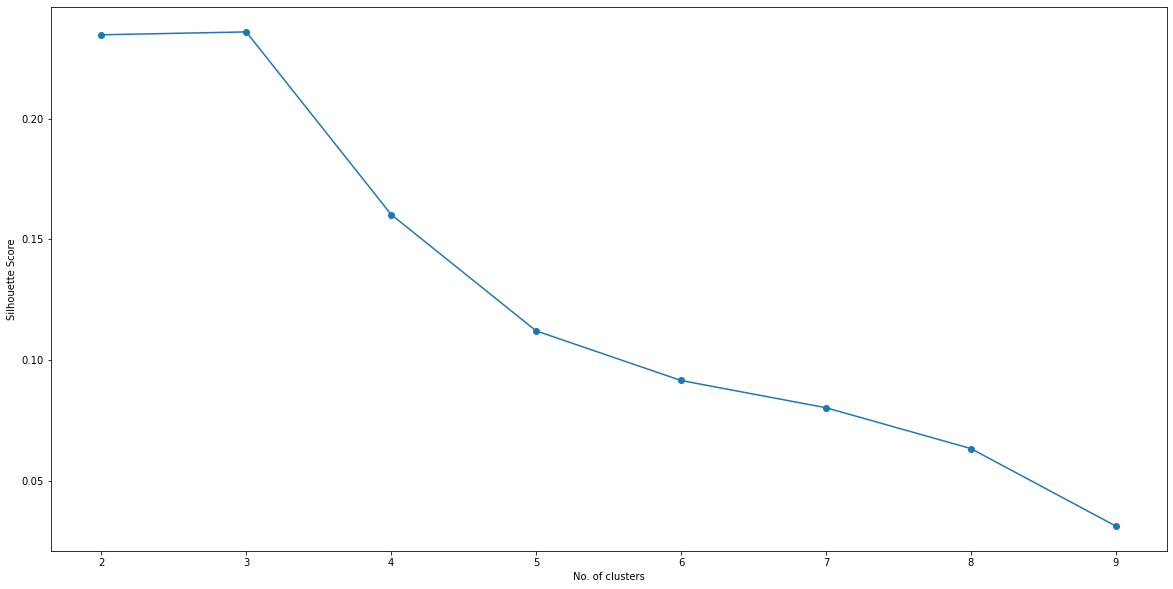

In [27]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [28]:
zip_iterator = zip(indices, scores)
scoresDict = dict(zip_iterator)
kcluster = max(scoresDict, key=scoresDict.get)
print('The optimal number of clusters is: ', kcluster)

The optimal number of clusters is:  3


In [29]:
#Clusterin with the optimal number of clusters determined
kmeans1 = KMeans(n_clusters=kcluster, random_state=5).fit(cities_grouped_clustering)

In [30]:
# add clustering labels
neighborhoods_venues_sorted['ClusterLabels'] = kmeans1.labels_

citiesDf = neighborhoods_venues_sorted

# merge citiesDf with the latitude/longitude data for each city
citiesDf = citiesDf.join(citiesCoords.set_index('Cities'), on='Cities')
citiesDf

,Cities,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,ClusterLabels,Latitude,Longitude,Population
0,AMBATO,Hotel,Mexican Restaurant,Pizza Place,Restaurant,Seafood Restaurant,1,-1.24917,-78.62997,178538.0
1,CALDERON,Seafood Restaurant,Pizza Place,Zoo,Italian Restaurant,Coffee Shop,2,-0.08083,-78.42219,152242.0
2,CUENCA,Restaurant,Italian Restaurant,BBQ Joint,Hotel,Latin American Restaurant,1,-2.89310,-78.99410,331888.0
3,GUAYAQUIL,Seafood Restaurant,Coffee Shop,Latin American Restaurant,Café,Pizza Place,0,-2.15960,-79.92830,2291158.0
4,IBARRA,Hotel,Pizza Place,Bar,Seafood Restaurant,Coffee Shop,1,0.36509,-78.10613,139721.0
5,LOJA,Seafood Restaurant,Fast Food Restaurant,Pizza Place,Café,Restaurant,1,-4.02156,-79.20295,180617.0
6,MACHALA,Seafood Restaurant,Fast Food Restaurant,Hotel,American Restaurant,Restaurant,0,-3.26267,-79.96053,241606.0
7,PORTOVIEJO,Seafood Restaurant,Mexican Restaurant,Latin American Restaurant,Breakfast Spot,Hotel,0,-1.05563,-80.45318,223086.0
8,QUITO,Coffee Shop,Restaurant,Hotel,Café,Italian Restaurant,1,-0.20565,-78.50888,1619146.0
9,RIOBAMBA,Hotel,Fast Food Restaurant,American Restaurant,Restaurant,Mexican Restaurant,1,-1.66378,-78.64094,156723.0


## Results <a name="results"></a>

#### Visualize the clusters

In [31]:
map_clusters = folium.Map(location=[latitudeEcu, longitudeEcu], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kcluster)
ys = [i + x + (i*x)**2 for i in range(kcluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(citiesDf['Latitude'], citiesDf['Longitude'], citiesDf['Cities'], citiesDf['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine each Cluster

In [32]:
citiesDf[citiesDf['ClusterLabels'] == 0]

,Cities,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,ClusterLabels,Latitude,Longitude,Population
3,GUAYAQUIL,Seafood Restaurant,Coffee Shop,Latin American Restaurant,Café,Pizza Place,0,-2.15960,-79.92830,2291158.0
6,MACHALA,Seafood Restaurant,Fast Food Restaurant,Hotel,American Restaurant,Restaurant,0,-3.26267,-79.96053,241606.0
7,PORTOVIEJO,Seafood Restaurant,Mexican Restaurant,Latin American Restaurant,Breakfast Spot,Hotel,0,-1.05563,-80.45318,223086.0


In [33]:
citiesDf[citiesDf['ClusterLabels'] == 1]

,Cities,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,ClusterLabels,Latitude,Longitude,Population
0,AMBATO,Hotel,Mexican Restaurant,Pizza Place,Restaurant,Seafood Restaurant,1,-1.24917,-78.62997,178538.0
2,CUENCA,Restaurant,Italian Restaurant,BBQ Joint,Hotel,Latin American Restaurant,1,-2.89310,-78.99410,331888.0
4,IBARRA,Hotel,Pizza Place,Bar,Seafood Restaurant,Coffee Shop,1,0.36509,-78.10613,139721.0
5,LOJA,Seafood Restaurant,Fast Food Restaurant,Pizza Place,Café,Restaurant,1,-4.02156,-79.20295,180617.0
8,QUITO,Coffee Shop,Restaurant,Hotel,Café,Italian Restaurant,1,-0.20565,-78.50888,1619146.0
9,RIOBAMBA,Hotel,Fast Food Restaurant,American Restaurant,Restaurant,Mexican Restaurant,1,-1.66378,-78.64094,156723.0


In [34]:
citiesDf[citiesDf['ClusterLabels'] == 2]

,Cities,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,ClusterLabels,Latitude,Longitude,Population
1,CALDERON,Seafood Restaurant,Pizza Place,Zoo,Italian Restaurant,Coffee Shop,2,-0.08083,-78.42219,152242.0


## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify the most common venues of the cities with the highest population in Ecuador. This analysis is oriented to the tourism industry, so we only review the following main categories of venues: Arts & Entertainment, Nightlife Spot, Food, Travel & Transport. Due to the limitation of venues reported by Fourquare, the data was reduced only to the top 10 cities.

Clustering of venues' frequencies was then performed in order to identify if there is a relation between the common venues and the regions of Ecuador (the cities analyzed correspond to two regions: the Andes and the Pacific Coast). Three clusters were obtained, and we could confirm the relation across the most common venues and the cities of each region. The cluster 2 contain only one rural zone called Calderon near the city of Quito. In the last four years, Calderon went from a rural zone to a strong urban development pole. 

Across all the clusters the gastronomy or food is the most common category venue. And we could evidence a lack of venues related with transportation services like bike or car rental venues.